## 2d prediction maps

Inspirations: 

* [Plot classifier comparison - scikit-learn](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
* [TensorFlow playground](https://playground.tensorflow.org/)
* [Which Machine Learning algorithm are you?](https://github.com/stared/which-ml-are-you)

Take a note that is feature is experimental as of 0.4.1.

In this case it uses PyTorch, but can be attached to other things. You need to use a different `predict` method.

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from livelossplot import PlotLosses
from livelossplot import matplotlib_subplots

In [2]:
# try with make_moons
X, y = datasets.make_circles(noise=0.2, factor=0.5, random_state=1)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

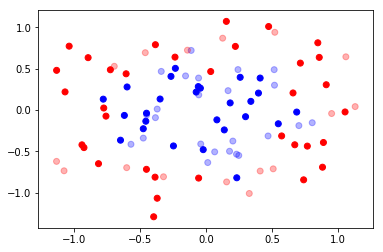

In [3]:
# plot them
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.3)

In [4]:
# PyTorch technicalities - loading and trainin
dataloaders = {
    'train':
    DataLoader(TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long()),
               batch_size=32,
               shuffle=True, num_workers=4),
    'validation': 
    DataLoader(TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long()),
               batch_size=32,
               shuffle=False, num_workers=4)
}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def train_model(model, criterion, optimizer, num_epochs=10,
                liveloss=PlotLosses()):
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (preds == labels.data).sum().item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss
            logs[prefix + 'accuracy'] = epoch_acc
        
        liveloss.update(logs)
        liveloss.draw()

In [5]:
# an old-school neural network: a multi-layer perceptron

class MLP(nn.Module):
    def __init__(self, hidden_size=3, activation=nn.ReLU()):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(2, hidden_size),
            activation,
            nn.Linear(hidden_size, 2)
        )
    
    def forward(self, x):
        x = self.fc(x)
        return x

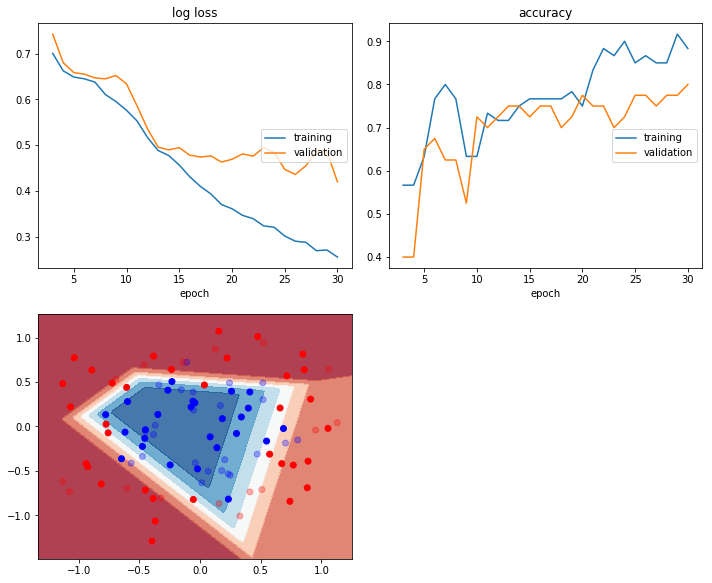

log loss:
training   (min:    0.255, max:    0.722, cur:    0.255)
validation (min:    0.420, max:    0.743, cur:    0.420)

accuracy:
training   (min:    0.500, max:    0.917, cur:    0.883)
validation (min:    0.400, max:    0.800, cur:    0.800)


In [6]:
model = MLP(6)

plot2d = matplotlib_subplots.Plot2d(model, X_train, y_train,
                                    valiation_data=(X_test, y_test),
                                    margin=0.2, h=0.02)
plot2d.predict = plot2d._predict_pytorch
liveloss = PlotLosses(cell_size=(5, 6), extra_plots=[plot2d])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-1)

train_model(model, criterion, optimizer, num_epochs=30,
            liveloss=liveloss)

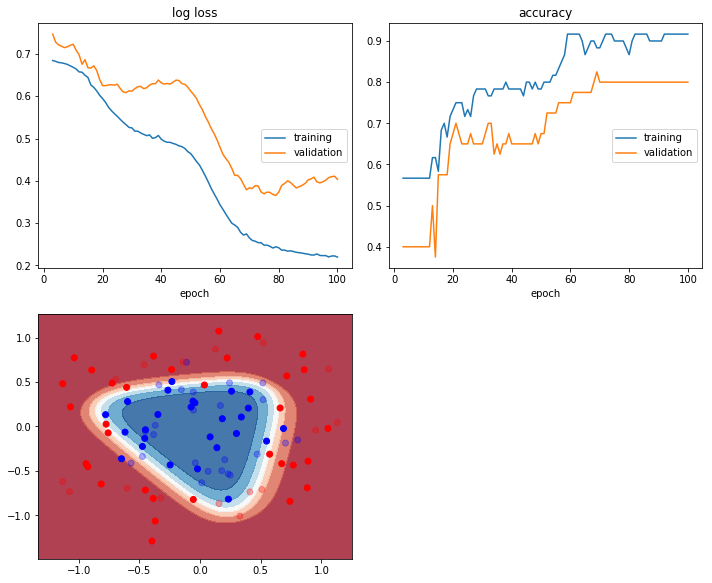

log loss:
training   (min:    0.220, max:    0.704, cur:    0.220)
validation (min:    0.365, max:    0.756, cur:    0.404)

accuracy:
training   (min:    0.517, max:    0.917, cur:    0.917)
validation (min:    0.350, max:    0.825, cur:    0.800)


In [7]:
model = MLP(3, activation=nn.Sigmoid())

plot2d = matplotlib_subplots.Plot2d(model, X_train, y_train,
                                    valiation_data=(X_test, y_test),
                                    margin=0.2, h=0.02)
plot2d.predict = plot2d._predict_pytorch
liveloss = PlotLosses(cell_size=(5, 6), extra_plots=[plot2d])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-1)

train_model(model, criterion, optimizer, num_epochs=100,
            liveloss=liveloss)

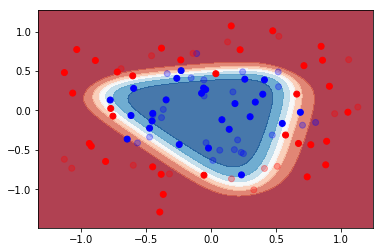

In [8]:
# if needed, we can draw it as a separate plot
plot2d.draw()